In [133]:
from feast import FeatureStore
from sklearn.model_selection import train_test_split,RandomizedSearchCV 
from sklearn.metrics import accuracy_score,classification_report 
from joblib import dump
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from joblib import load

In [134]:
# Getting our FeatureStore
store = FeatureStore(repo_path=".")

In [135]:
# Retrieving the saved dataset and converting it to a DataFrame
training_df = store.get_saved_dataset(name="churn_dataset").to_df()
training_df

C:\Users\damia\AppData\Roaming\Python\Python311\site-packages\feast\feature_store.py:1178: RuntimeWarning: Retrieving datasets is an experimental feature. This API is unstable and it could and most probably will be changed in the future. We do not guarantee that future changes will maintain backward compatibility.
  warnings.warn(


,EstimatedSalary,Geography_Spain,Gender,HasCrCard,Tenure,CreditScore,Geography_France,USER_ID,event_timestamp,NumOfProducts,Age,IsActiveMember,Balance,Exited,Geography_Germany
0,18922.18,False,0,1,4,792,False,3618,2023-01-01 00:00:00+00:00,1,29,0,107601.79,1,True
1,136643.84,False,0,0,3,686,True,3152,2023-01-01 00:00:00+00:00,1,39,0,111695.62,0,False
2,195771.95,False,0,1,9,572,False,4195,2023-01-01 00:00:00+00:00,1,54,1,97382.53,0,True
3,142454.77,False,1,0,6,643,True,8080,2023-01-01 00:00:00+00:00,2,37,0,0.00,0,False
4,8908.00,True,1,1,1,587,False,2599,2023-01-01 00:00:00+00:00,2,48,1,0.00,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,186105.99,False,0,1,7,764,True,1195,2023-12-31 00:00:00+00:00,2,24,0,0.00,0,False
9996,92053.75,False,1,1,3,850,False,4492,2023-12-31 00:00:00+00:00,1,61,1,141784.02,0,True
9997,182867.84,False,1,1,10,744,True,9303,2023-12-31 00:00:00+00:00,2,36,1,0.00,0,False
9998,89874.82,False,1,1,4,850,False,6664,2023-12-31 00:00:00+00:00,1,31,1,146587.30,0,True


In [136]:
# Separating the features and labels
labels = training_df['Exited']
features = training_df.drop(
    labels=['Exited', 'event_timestamp', "USER_ID"],
    axis=1)

In [137]:
# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    stratify=labels)

In [138]:
columns_order = load(r'data/columns_order.joblib')
columns_order

Index(['Gender', 'CreditScore', 'HasCrCard', 'EstimatedSalary', 'Tenure',
       'IsActiveMember', 'NumOfProducts', 'Geography_France',
       'Geography_Spain', 'Age', 'Geography_Germany', 'Balance'],
      dtype='object')

In [139]:
# Riorganizza le colonne di X_test in base all'ordine delle colonne utilizzate durante l'addestramento
X_test = X_test[columns_order]
X_train = X_train[columns_order]

### Train - Random Forest

In [140]:
# Inizializza il modello
forest = RandomForestClassifier(n_estimators=100, random_state=42)
# Addestra il modello
forest.fit(X=X_train, y=y_train)
# predict the mode 
y_pred = forest.predict(X_test) 
  
# performance evaluatio metrics 
print(classification_report(y_pred, y_test)) 

              precision    recall  f1-score   support

           0       0.97      0.87      0.92      2216
           1       0.44      0.79      0.56       284

    accuracy                           0.86      2500
   macro avg       0.70      0.83      0.74      2500
weighted avg       0.91      0.86      0.88      2500



In [141]:
dump(forest, r'models/random_forest_model.joblib')

['models/random_forest_model.joblib']

In [142]:
X_train.columns

Index(['Gender', 'CreditScore', 'HasCrCard', 'EstimatedSalary', 'Tenure',
       'IsActiveMember', 'NumOfProducts', 'Geography_France',
       'Geography_Spain', 'Age', 'Geography_Germany', 'Balance'],
      dtype='object')

In [143]:
# Load random forest model
logistic = load(r'models/logistic_regression.joblib')

In [144]:
y_pred_prob_1 = forest.predict_proba(X_test)[:, 1]
y_pred_prob_2 = logistic.predict_proba(X_test)[:, -1]

In [145]:
fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, y_pred_prob_1)
auc_1 = roc_auc_score(y_test, y_pred_prob_1)

In [146]:
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_pred_prob_2)
auc_2 = roc_auc_score(y_test, y_pred_prob_2)

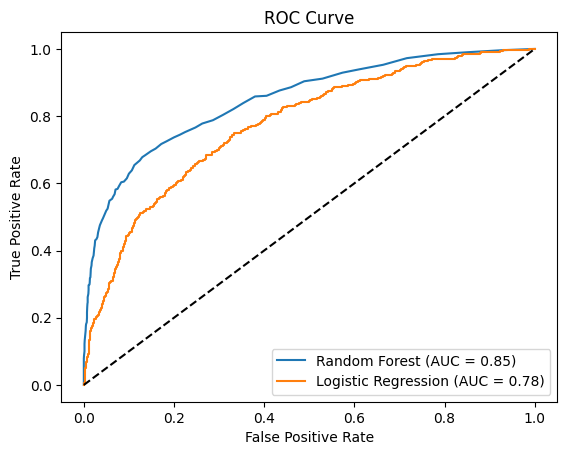

In [147]:
plt.plot(fpr_1, tpr_1, label=f'Random Forest (AUC = {auc_1:.2f})')
plt.plot(fpr_2, tpr_2, label=f'Logistic Regression (AUC = {auc_2:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Hyperparameter-tuning random forest

In [148]:
rf_params = {
    'n_estimators': [100, 200, 300], 
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [149]:
rf_random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                                      param_distributions=rf_params, n_iter=100, cv=5, random_state=42)
rf_random_search.fit(X_train, y_train)

In [ ]:

y_pred_rf_rs = rf_random_search.predict(X_test)
print("\n Random Forest Randomized Search Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_rs))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf_rs))

